### Загружаем данные

In [1]:
import pandas as pd
import re
%matplotlib inline

data = pd.read_csv('./data/titanic/train.csv') 
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Предаварительный анализ

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
data.SibSp.unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

In [4]:
data.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [5]:
data.Parch.unique()

array([0, 1, 2, 5, 3, 4, 6], dtype=int64)

In [6]:
data.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

### Немного преобразуем данные

In [7]:
data.drop_duplicates(inplace = True)

In [8]:
data.Age.nlargest()

630    80.0
851    74.0
96     71.0
493    71.0
116    70.5
Name: Age, dtype: float64

In [9]:
data.Age.fillna(data.Age.median(), inplace = True)

In [10]:
data.Cabin.fillna('no_cabin', inplace = True)

In [11]:
data.Embarked.fillna('no_literal', inplace = True)

In [12]:
data['Deck'] = data.Cabin.apply(lambda x: re.sub(r'[^\D]', '', x) )
data['Cabin'] = data.Cabin.apply(lambda x: re.sub(r'[\D]', '', x) )
data.Cabin.replace({'':0}, inplace=True)
data.Deck.replace({ 'B B': 'B', 
                   'B B B': 'B', 
                   'B B B B': 'B', 
                   'C C':'C', 
                   'C C C':'C', 
                   'D D':'D', 
                   'F G': 'F', 
                   'F E': 'E'
                  }, 
                  inplace=True)
data['Relatives'] = data.SibSp + data.Parch
#bins = pd.IntervalIndex.from_tuples([(-1, 50), (50, 150), (150, 550)])
bins_t = [-0.01, 50, 150, 550]
bins_a = [-0.01, 15, 40, 81]
data['Ticket_group'] = pd.cut(data.Fare, bins_t, labels = ["cheap", "medium", "expensive"])
data['Age_group'] = pd.cut(data.Age, bins_a, labels = ["young", "adult", "old"])

In [13]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Relatives,Ticket_group,Age_group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,no_cabin,1,cheap,adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,85,C,C,1,medium,adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,no_cabin,0,cheap,adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,123,S,C,1,medium,adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,no_cabin,0,cheap,adult


### 1. Известна история, что в первую очередь спасали женщин и детей, также предполагаю, что с нижних палуб было тяжелей выбраться

In [14]:
data.groupby(['Sex', 'Deck'])['Survived'].apply(lambda x: x.sum()/x.count())

Sex     Deck    
female  A           1.000000
        B           1.000000
        C           0.888889
        D           1.000000
        E           0.937500
        F           1.000000
        G           0.500000
        no_cabin    0.654378
male    A           0.428571
        B           0.400000
        C           0.343750
        D           0.466667
        E           0.588235
        F           0.375000
        T           0.000000
        no_cabin    0.136170
Name: Survived, dtype: float64

### Видно, что у женщин высокая выживаемость, за исключением самых нижних палуб. У мужчин выживаемость ниже 50%, а с нижних палуб мало кто спасся.

### 2. Предполагаю, что у детей и стариков может быть выживаемость больше, чем у взрослых, опять же на нижних палубах она у всех должна быть ниже

In [15]:
data.groupby(['Age_group', 'Deck'])['Survived'].apply(lambda x: x.sum()/x.count())

Age_group  Deck    
young      A           1.000000
           B           1.000000
           C           0.500000
           D                NaN
           E           1.000000
           F           1.000000
           G           0.500000
           T                NaN
           no_cabin    0.542857
adult      A           0.250000
           B           0.800000
           C           0.675000
           D           0.777778
           E           1.000000
           F           0.428571
           G           0.500000
           T                NaN
           no_cabin    0.275797
old        A           0.666667
           B           0.571429
           C           0.411765
           D           0.733333
           E           0.333333
           F           0.000000
           G                NaN
           T           0.000000
           no_cabin    0.250000
Name: Survived, dtype: float64

### Видим, что у детей выживаемость высокая, практически вне зависимости от палубы, у взрослых среднего возраста выживаемость зависит от палубы: наибольшая на В, D, E. У пожилых людей выживаемость всё таки хуже. Посмотрим по количество в возрастных группах:

In [16]:
data.groupby(['Age_group'])['Age'].count()

Age_group
young     83
adult    658
old      150
Name: Age, dtype: int64

### В любом случае людей среднего возраста погибло больше, чем в других группах, а пожилых больше, чем детей

### 3. Может быть, люди с более дорогими билетами лучше выживали в разрезе палуб

In [17]:
data.groupby(['Ticket_group', 'Deck'])['Survived'].apply(lambda x: x.sum()/x.count())

Ticket_group  Deck    
cheap         A           0.454545
              B           0.400000
              C           0.500000
              D           0.666667
              E           0.764706
              F           0.583333
              G           0.500000
              T           0.000000
              no_cabin    0.287037
medium        A           0.500000
              B           0.821429
              C           0.678571
              D           0.809524
              E           0.750000
              F                NaN
              G                NaN
              T                NaN
              no_cabin    0.470588
expensive     A                NaN
              B           0.888889
              C           0.533333
              D                NaN
              E                NaN
              F                NaN
              G                NaN
              T                NaN
              no_cabin    0.800000
Name: Survived, dtype: float64

### Да, кажется, что у пассажиров с дорогими билетами всё же выживаемость выше. По средней и дешёвой стоимости как-то явно не отличаются, хоть у средней и повыше.

### 4. Выживаемость зависит от возраста и стоимости билета?

In [18]:
data.groupby(['Ticket_group', 'Age_group'])['Survived'].apply(lambda x: x.sum()/x.count())

Ticket_group  Age_group
cheap         young        0.571429
              adult        0.295082
              old          0.257143
medium        young        1.000000
              adult        0.707865
              old          0.589744
expensive     young        0.666667
              adult        0.650000
              old          0.833333
Name: Survived, dtype: float64

### Да, пожилые пассажиры с дорогим билетом выживали лучше даже, чем дети с дешёвым билетом. По средней стоимости билетов распределение более менее ожидаемое.

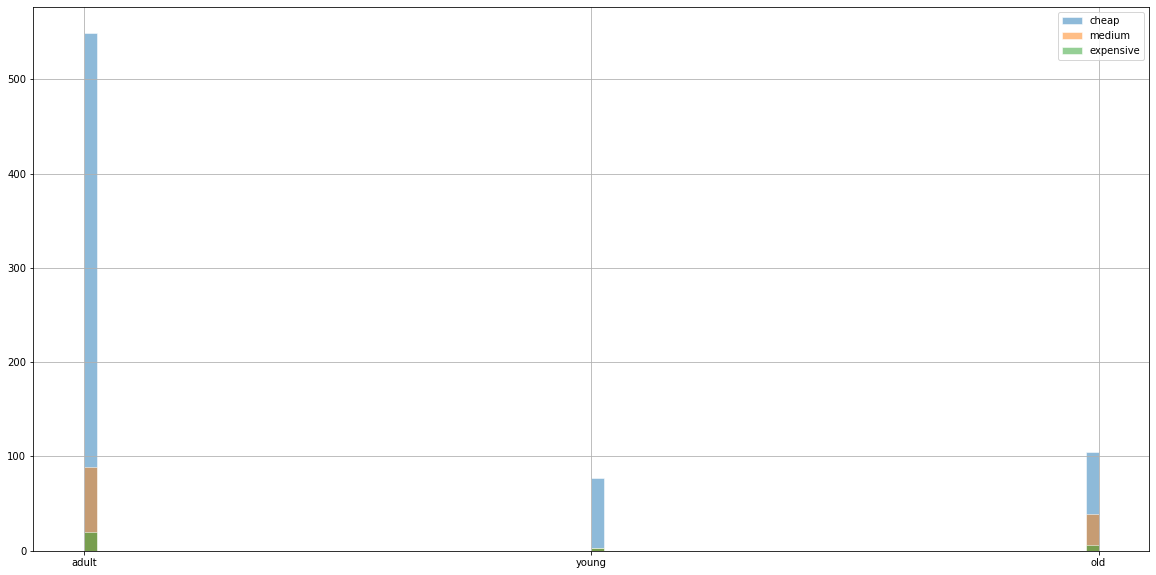

In [19]:
ax =data[data['Ticket_group'] == 'cheap']['Age_group'].hist(figsize=(20, 10), bins=80, edgecolor='white', alpha=0.5)
data[data['Ticket_group'] == 'medium']['Age_group'].hist(figsize=(20, 10), bins=80, edgecolor='white', alpha=0.5)
data[data['Ticket_group'] == 'expensive']['Age_group'].hist(figsize=(20, 10), bins=80, edgecolor='white', alpha=0.5)

ax.legend(['cheap', 'medium', 'expensive'])

### 5. По полу и возрасту?

In [20]:
data.groupby(['Sex', 'Age_group'])['Survived'].apply(lambda x: x.sum()/x.count())

Sex     Age_group
female  young        0.651163
        adult        0.753363
        old          0.770833
male    young        0.525000
        adult        0.160920
        old          0.176471
Name: Survived, dtype: float64

### Не особо репрезентативно. Понятно, что женщины выживали лучше. У мальчиков шанс выжить был выше, чем у мужчин, а вот у девочек почему-то ниже, чем у женщин (наверное, испугались и спрятались где-нибудь, поэтому не успели спастись)

In [21]:
data[(data['Age_group'] == 'old')&(data['Sex'] == 'female')]['Age'].count()

48

### 6. Влияет ли класс и возрастная группа?

In [22]:
data.groupby(['Pclass', 'Age_group'])['Survived'].apply(lambda x: x.sum()/x.count())

Pclass  Age_group
1       young        0.833333
        adult        0.686567
        old          0.513158
2       young        1.000000
        adult        0.419847
        old          0.382353
3       young        0.431034
        adult        0.231552
        old          0.075000
Name: Survived, dtype: float64

### За исключение позиции по детям - да, влияет. 

### 7. Добавим пол пассажиров

In [23]:
data.groupby(['Pclass', 'Sex', 'Age_group'])['Survived'].apply(lambda x: x.sum()/x.count())

Pclass  Sex     Age_group
1       female  young        0.666667
                adult        0.984615
                old          0.961538
        male    young        1.000000
                adult        0.405797
                old          0.280000
2       female  young        1.000000
                adult        0.924528
                old          0.846154
        male    young        1.000000
                adult        0.076923
                old          0.095238
3       female  young        0.533333
                adult        0.523810
                old          0.111111
        male    young        0.321429
                adult        0.125000
                old          0.064516
Name: Survived, dtype: float64

### В целом, ничего нового: в третьем классе выживаемость самая плохая, лучше выживают женщины, у них в 1 и 2 классах всё сопоставимо, но зато мы определили, что статиску выживаемости девочек относительно женщин испортили девочки из первого класса (слишком нежное воспитание и неспособность самостоятельно принять решение или в этом классе девочки были ещё несамостоятельными детьми?)

In [24]:
data[(data['Age_group'] == 'young')&(data['Sex'] == 'female')&(data['Pclass'] == 1)]['Age'].unique()

array([ 2., 14., 15.])

In [25]:
data[(data['Age_group'] == 'young')&(data['Sex'] == 'female')&(data['Pclass'] == 1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Relatives,Ticket_group,Age_group
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.5500,2226,S,C,3,expensive,young
435,436,1,1,"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0000,9698,S,B,3,medium,young
689,690,1,1,"Madill, Miss. Georgette Alexandra",female,15.0,0,1,24160,211.3375,5,S,B,1,expensive,young


### Да, несамостоятельная девочка 2 лет не выжила

### 8. В зависимости от количества родстенников?

In [26]:
data.groupby(['Deck', 'Relatives'])['Survived'].apply(lambda x: x.sum()/x.count())

Deck      Relatives
A         0            0.333333
          1            1.000000
          2            1.000000
B         0            0.636364
          1            0.785714
          2            0.800000
          3            1.000000
          4            1.000000
C         0            0.590909
          1            0.652174
          2            0.571429
          3            0.333333
          5            0.500000
D         0            0.692308
          1            0.812500
          2            0.750000
E         0            0.705882
          1            0.800000
          2            0.833333
F         0            0.428571
          2            0.666667
          3            1.000000
G         1            0.000000
          2            0.666667
T         0            0.000000
no_cabin  0            0.243792
          1            0.421053
          2            0.520548
          3            0.700000
          4            0.076923
          5         

### В общем, если родственников от 1 до 3, то шансы выжить выше на всех палубах

In [27]:
data = pd.get_dummies(data, columns = ['Sex', 'Embarked', 'Deck', 'Ticket_group', 'Age_group'])

### Посмотрим heatmap: способствовали выживанию высокая/средняя стоимость билета, женский пол, немножко повезло, если сел в порту С, а разместился на палубе В или D. Нелинейные зависимости не рассматривались.

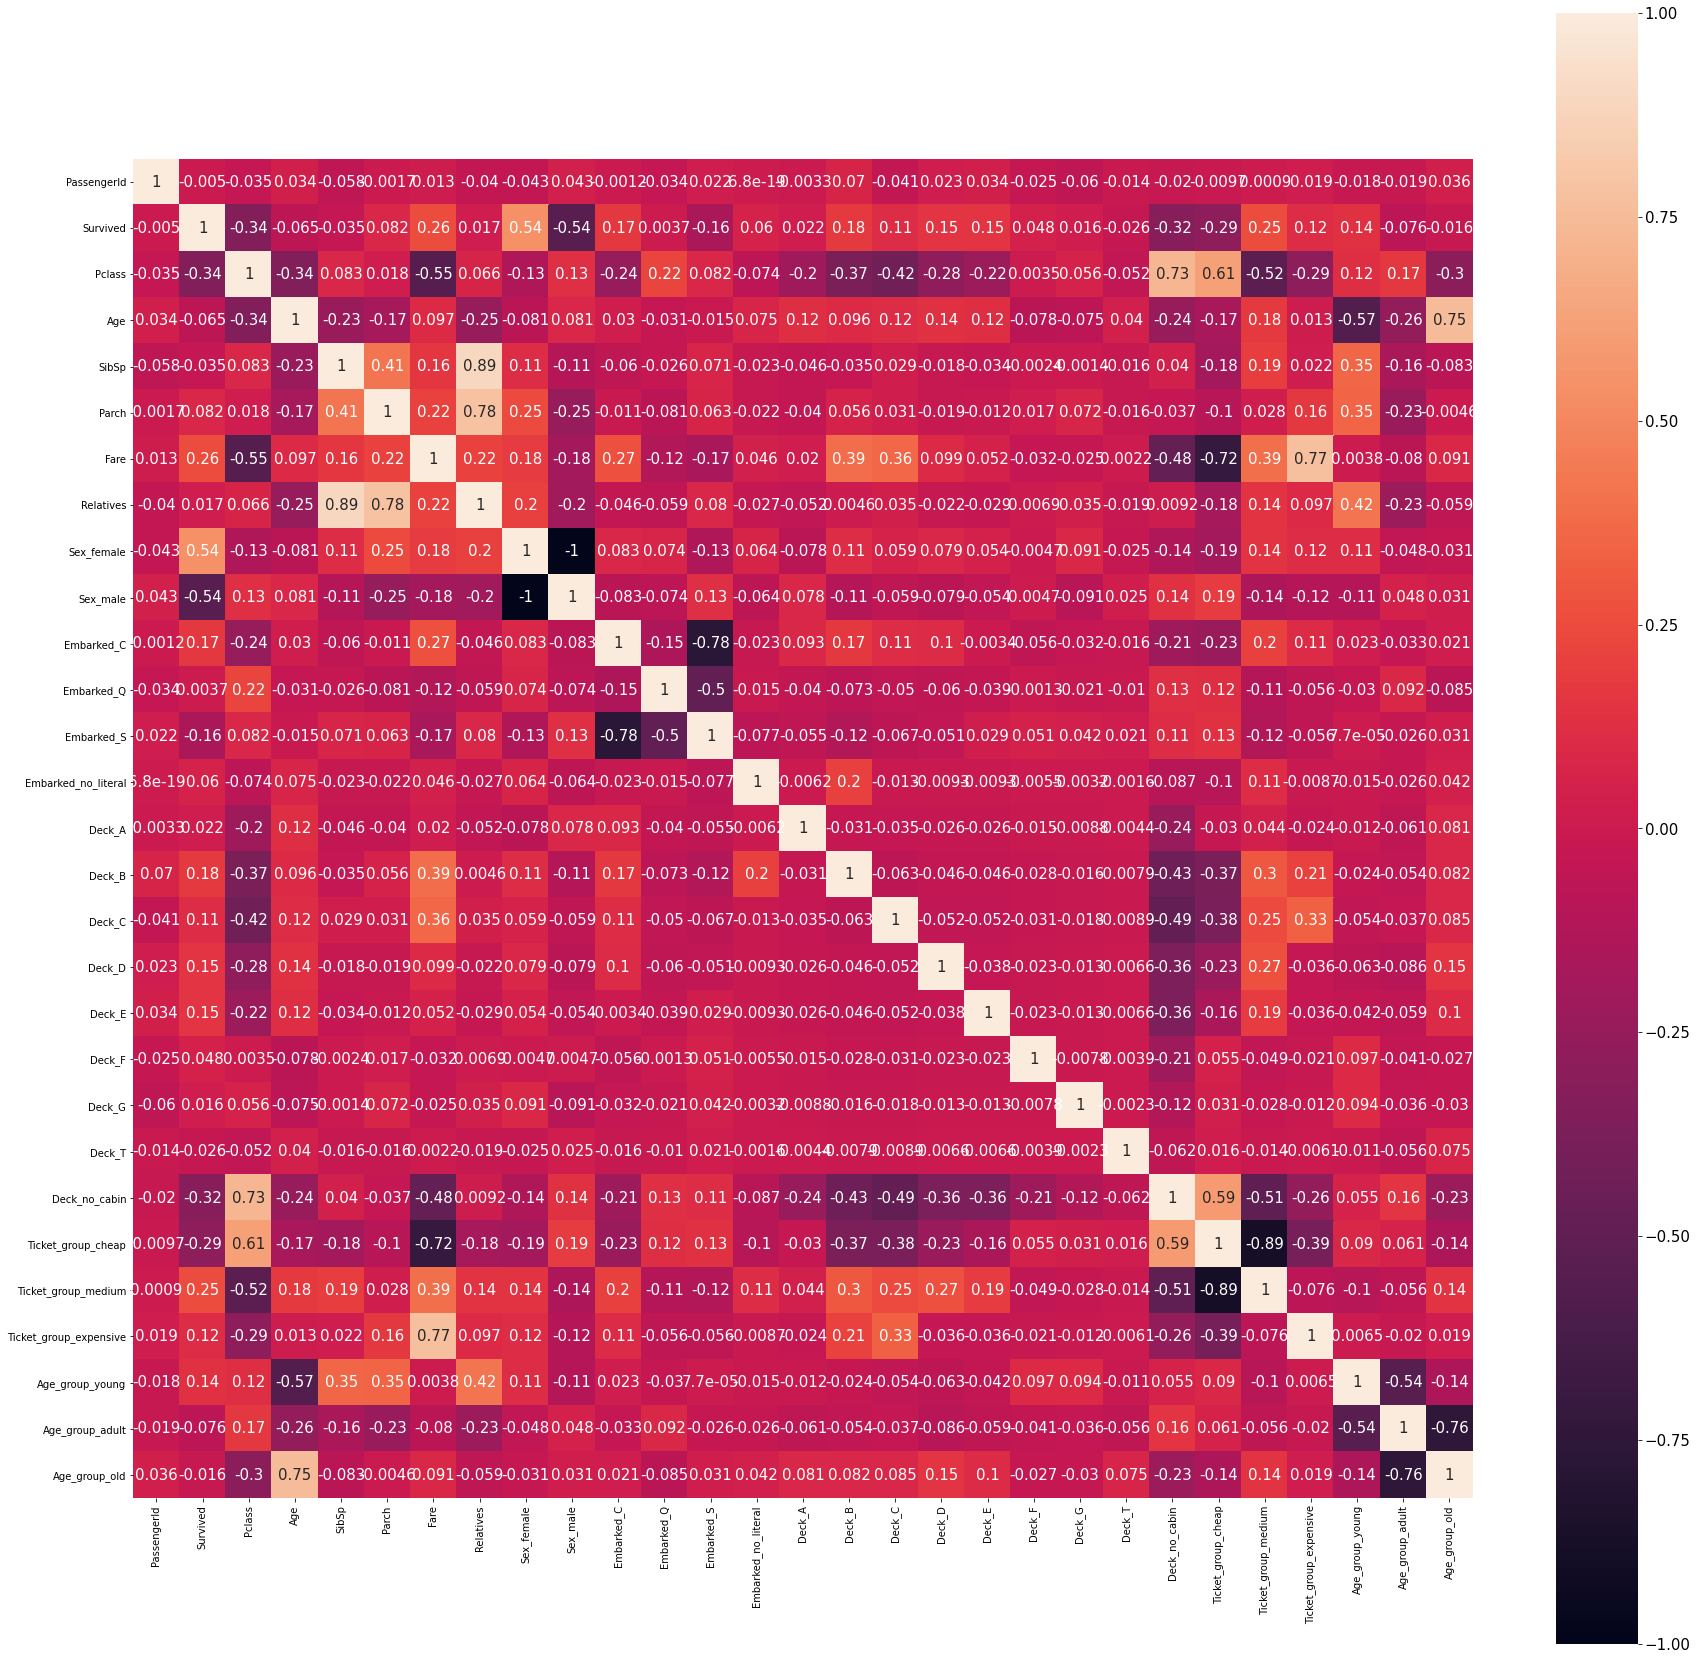

In [28]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.subplots(figsize=(30,30))
plt.rcParams.update({'font.size': 15})
sns.heatmap(data.corr(), square=True, annot = True)
plt.show()